# 5. 인공신경망
## 5.1 다층 퍼셉트론
### 5.1.1 선형 회귀

In [21]:
import torch
import torch.nn as nn
from matplotlib import pyplot as plt

In [22]:
x = torch.FloatTensor(range(5)).unsqueeze(1)
print(x)
y = 2*x + torch.rand(5,1)
print(y)

tensor([[0.],
        [1.],
        [2.],
        [3.],
        [4.]])
tensor([[0.2585],
        [2.9540],
        [4.6928],
        [6.7274],
        [8.6581]])


In [23]:
#선형 회귀
class LinearRegressor(nn.Module): #nn.Module 상속
    def __init__(self):
        super().__init__() # 모델 연산 정의
        self.fc = nn.Linear(1, 1, bias=True) #y=wx+b (x와 y의 개수가 1개)
    
    def forward(self, x):  #실제 입력값이 들어와서 연산이 진행되는 순서와 방법
        y = self.fc(x) # self.fc() 에 x 값을 넣어서 y값 추출
      
        return y  

In [24]:
model = LinearRegressor() #model 인스턴스 만들기

In [26]:
model.parameters()

<generator object Module.parameters at 0x7ff739d85cf0>


In [28]:
learning_rate = 1e-3 #학습률
criterion = nn.MSELoss() #손실함수 =MSELoss 
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) # 최적화 방법에 모댈의 파라미터 사용

In [29]:
loss_stack = [] #loss 쌓아두기
for epoch in range(1001):
    
    optimizer.zero_grad() #에폭 마다 누적된 계산 값을 0으로 초기화
    
    y_hat = model(x) # 예측값 산출
    loss = criterion(y_hat,y) #MSE Loss 구하기
    
    loss.backward() #역전파 - 손실함수 미분해서 진행 
    optimizer.step() # optimizer로 최적화
    loss_stack.append(loss.item()) # loss 값 저장 
    
    if epoch % 100 == 0: #100 epoch 마다 loss 표현
        print(f'Epoch {epoch}:{loss.item()}')

Epoch 0:11.446232795715332
Epoch 100:0.8705340623855591
Epoch 200:0.15223607420921326
Epoch 300:0.09798865765333176
Epoch 400:0.08909044414758682
Epoch 500:0.08383448421955109
Epoch 600:0.07934771478176117
Epoch 700:0.07537799328565598
Epoch 800:0.07185585796833038
Epoch 900:0.06873024255037308
Epoch 1000:0.06595643609762192


In [7]:
with torch.no_grad(): #예측은 학습이 아니기 때문에 gradient 없이 한다는 것을 지정
    y_hat = model(x)

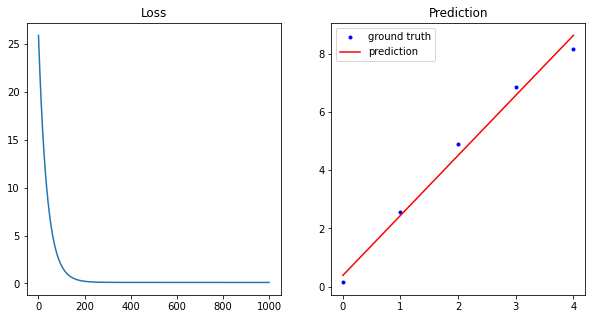

In [8]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(loss_stack)
plt.title("Loss")
plt.subplot(122)
plt.plot(x, y,'.b')
plt.plot(x, y_hat, 'r-')
plt.legend(['ground truth','prediction'])
plt.title("Prediction")
plt.show()

#### 5.1.2 집값 예측하기

변수들은 보통 비선형이기 때문에 선형 모델을 가지고 예측하는 것은 무리가 있음   
따라서 여러 선형 모델을 겹쳐서 다층 신경망을 만들어서 예측

In [1]:
import pandas as pd # 데이터프레임 형태를 다룰 수 있는 라이브러리
import numpy as np
from sklearn.model_selection import train_test_split # 전체 데이터를 학습 데이터와 평가 데이터로 나눈다.

# ANN
import torch
from torch import nn, optim # torch 내의 세부적인 기능을 불러온다. (신경망 기술, 손실함수, 최적화 방법 등)
from torch.utils.data import DataLoader, Dataset # 데이터를 모델에 사용할 수 있도록 정리해 주는 라이브러리
import torch.nn.functional as F # torch 내의 세부적인 기능을 불러온다. (신경망 기술 등)

# Loss
from sklearn.metrics import mean_squared_error # Regression 문제의 평가를 위해 MSE(Mean Squared Error)를 불러온다.
#RMSE 를 사용 예정이지만 MSE에 루트를 씌워서 사용

# Plot
import matplotlib.pyplot as plt # 시각화 도구


In [2]:
df = pd.read_csv('reg.csv', index_col=[0])

In [17]:
len(df)

506

In [3]:
# 데이터프레임 보여주기
# df.head()는 상위 5줄만 보여준다.
# df.head(10) 괄호 안에 숫자 10을 넣으면 10줄을 보여준다. 
df.head(10) 

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,Price
0,0.034633,0.206919,0.137057,0.540526,0.193941,0.699239,0.630532,0.239410,0.027375,0.209857,0.347609,0.996394,0.102644,0.422222
1,0.028920,0.014315,0.276113,0.255945,0.618886,0.555407,0.782263,0.482977,0.103031,0.106690,0.520776,0.996650,0.187120,0.368889
2,0.020627,0.033230,0.281116,0.525591,0.165269,0.624102,0.586005,0.272713,0.036010,0.106986,0.595301,0.983284,0.084079,0.660000
3,0.022749,0.033801,0.125044,0.263253,0.251509,0.658532,0.432160,0.344932,0.150018,0.068317,0.651297,0.989989,0.015990,0.631111
4,0.022148,0.029374,0.121057,0.521126,0.399670,0.448086,0.520158,0.495342,0.104383,0.069360,0.560116,0.998723,0.092782,0.693333
5,0.038651,0.019568,0.139449,0.719852,0.560581,0.610531,0.578661,0.387926,0.133629,0.072967,0.514078,0.986385,0.127396,0.526667
6,0.033301,0.136658,0.336651,0.274996,0.472140,0.331155,0.643546,0.661869,0.270651,0.239929,0.475964,0.993516,0.300521,0.397778
7,0.026858,0.151993,0.300627,0.115449,0.463345,0.532618,0.938389,0.465781,0.139893,0.238901,0.243669,0.991425,0.431171,0.491111
8,0.021739,0.132378,0.259349,0.488716,0.389581,0.411536,0.984672,0.526151,0.201324,0.236329,0.306712,0.965204,0.767177,0.255556
9,0.014588,0.144471,0.331099,0.759479,0.696532,0.334544,0.834204,0.611416,0.174935,0.237351,0.437982,0.967070,0.445798,0.308889


In [9]:
# 데이터를 넘파이 배열로 만들기
X = df.drop('Price', axis=1).to_numpy() # 데이터프레임에서 타겟값(Price)을 제외하고 넘파이 배열로 만들기 feature들로만 배열로 만들기
Y = df['Price'].to_numpy().reshape((-1,1)) # 데이터프레임 형태의 타겟값을 넘파이 배열로 만들기 타겟 값을 배열로 만든다

print(X)
print(Y)

[[0.03463293 0.20691874 0.13705684 ... 0.34760885 0.99639409 0.10264398]
 [0.02892023 0.01431456 0.27611271 ... 0.52077557 0.99665033 0.18711954]
 [0.02062738 0.03322998 0.28111574 ... 0.59530071 0.98328389 0.0840788 ]
 ...
 [0.03535199 0.02149474 0.42391812 ... 0.78270371 0.99579054 0.09404364]
 [0.02618206 0.02860316 0.44344242 ... 0.74918576 0.9868548  0.10739872]
 [0.04551912 0.02928918 0.44615622 ... 0.83523695 0.99422078 0.14630181]]
[[0.42222222]
 [0.36888889]
 [0.66      ]
 [0.63111111]
 [0.69333333]
 [0.52666667]
 [0.39777778]
 [0.49111111]
 [0.25555556]
 [0.30888889]
 [0.22222222]
 [0.30888889]
 [0.37111111]
 [0.34222222]
 [0.29333333]
 [0.33111111]
 [0.40222222]
 [0.27777778]
 [0.33777778]
 [0.29333333]
 [0.19111111]
 [0.32444444]
 [0.22666667]
 [0.21111111]
 [0.23555556]
 [0.19777778]
 [0.25777778]
 [0.21777778]
 [0.29777778]
 [0.35555556]
 [0.17111111]
 [0.21111111]
 [0.18222222]
 [0.18      ]
 [0.18888889]
 [0.30888889]
 [0.33333333]
 [0.35555556]
 [0.43777778]
 [0.573333

In [10]:
class TensorData(Dataset): #dataloader

    def __init__(self, x_data, y_data):
        self.x_data = torch.FloatTensor(x_data)
        self.y_data = torch.FloatTensor(y_data)
        self.len = self.y_data.shape[0]

    def __getitem__(self, index): #index를 불러올 때 실행되는 것

        return self.x_data[index], self.y_data[index] 

    def __len__(self):
        return self.len

In [11]:
# 전체 데이터를 학습 데이터와 평가 데이터로 나눈다.
# 기준으로 잡은 논문이 전체 데이터를 50%, 50%로 나눴기 때문에 test size를 0.5로 설정한다.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5) #반반 나누어서 진행

# 학습 데이터, 시험 데이터 배치 형태로 구축하기
trainsets = TensorData(X_train, Y_train) #텐서 형태로 load 후에
trainloader = torch.utils.data.DataLoader(trainsets, batch_size=32, shuffle=True) #배치형태로 나누기

testsets = TensorData(X_test, Y_test)
testloader = torch.utils.data.DataLoader(testsets, batch_size=32, shuffle=False)

In [12]:
class Regressor(nn.Module): # 입력층 1개, 은닉층 2개 출력층 1개를 가진 모델
    def __init__(self):
        super().__init__() # 모델 연산 정의
        self.fc1 = nn.Linear(13, 50) # 입력층(13) -> 은닉층1(50)으로 가는 연산 => x feature 가 13개
        self.fc2 = nn.Linear(50, 30) # 은닉층1(50) -> 은닉층2(30)으로 가는 연산 => 50개 노드
        self.fc3 = nn.Linear(30, 1) # 은닉층2(30) -> 출력층(1)으로 가는 연산 => 30개 노드
        self.dropout = nn.Dropout(0.5) # 연산이 될 때마다 50%의 비율로 랜덤하게 노드를 없앤다. => 과적합을 방지하기 위해 
        
    def forward(self, x): # 모델 연산의 순서를 정의
        x = F.relu(self.fc1(x)) # Linear 계산 후 활성화 함수 ReLU를 적용한다.  
        x = self.dropout(F.relu(self.fc2(x))) # 은닉층2에서 드랍아웃을 적용한다.(즉, 30개의 50%인 15개의 노드가 계산에서 제외된다.)
        x = F.relu(self.fc3(x)) # Linear 계산 후 활성화 함수 ReLU를 적용한다.  
      
        return x
         
    
# 주의 사항
# 드랍아웃은 과적합(overfitting)을 방지하기 위해 노드의 일부를 배제하고 계산하는 방식이기 때문에 절대로 출력층에 사용해서는 안 된다.

In [13]:
model = Regressor()
criterion = nn.MSELoss() #loss function
# lr은 학습률이다.
# weight_decay는 L2 정규화에서의 penalty 정도를 의미한다.
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-7)

In [16]:
for data in trainloader: # 무작위로 섞인 32개 데이터가 있는 배치가 하나 씩 들어온다.

    print(data)

[tensor([[0.2863, 0.0459, 0.6436, 0.3963, 0.4100, 0.5842, 0.9334, 0.1825, 0.8118,
         0.9112, 0.8541, 0.9901, 0.6305],
        [0.0178, 0.0245, 0.3386, 0.4925, 0.2145, 0.4318, 0.7185, 0.2293, 0.1095,
         0.2250, 0.6508, 0.9946, 0.4192],
        [0.0901, 0.0135, 0.6884, 0.3870, 0.5510, 0.5793, 0.9416, 0.2458, 0.8617,
         0.9142, 0.7481, 0.7997, 0.4861],
        [0.1945, 0.0031, 0.6219, 0.4264, 0.6318, 0.5468, 0.9678, 0.1254, 0.8735,
         0.9113, 0.6715, 0.0877, 0.5196],
        [0.0320, 0.8033, 0.1501, 0.8825, 0.7998, 0.5342, 0.2866, 0.7891, 0.0000,
         0.1076, 0.5836, 0.8561, 0.2712],
        [0.0440, 0.0324, 0.4906, 0.4373, 0.5626, 0.4403, 0.4302, 0.2777, 0.2325,
         0.4081, 0.6650, 0.9700, 0.2464],
        [0.0298, 0.0206, 0.1587, 0.5000, 0.6261, 0.2958, 0.5524, 0.3430, 0.0590,
         0.1723, 0.5985, 0.8969, 0.1537],
        [0.0148, 0.0286, 0.2570, 0.3582, 0.3805, 0.3625, 0.5392, 0.6423, 0.1273,
         0.3145, 0.6655, 0.9148, 0.3345],
        [0.0194

In [14]:
loss_ = [] # 그래프를 그리기 위한 loss 저장용 리스트 
n = len(trainloader)
print(n)

for epoch in range(400): # 400번 학습을 진행한다.

    running_loss = 0.0

    for data in trainloader: # 무작위로 섞인 32개 데이터가 있는 배치가 하나 씩 들어온다. => 아래 내용은 batch 마다 진행

        inputs, values = data # data에는 X, Y가 들어있다. input = x , values = y
       
        optimizer.zero_grad() # 최적화 초기화

        outputs = model(inputs) # 모델에 입력값 대입 후 예측값 산출
        loss = criterion(outputs, values) # 손실 함수 계산
        loss.backward() # 손실 함수 기준으로 역전파 설정 
        optimizer.step() # 역전파를 진행하고 가중치 업데이트
        

        running_loss += loss.item() # epoch 마다 평균 loss를 계산하기 위해 배치 loss를 더한다. 

    loss_.append(running_loss/n) # MSE(Mean Squared Error) 계산



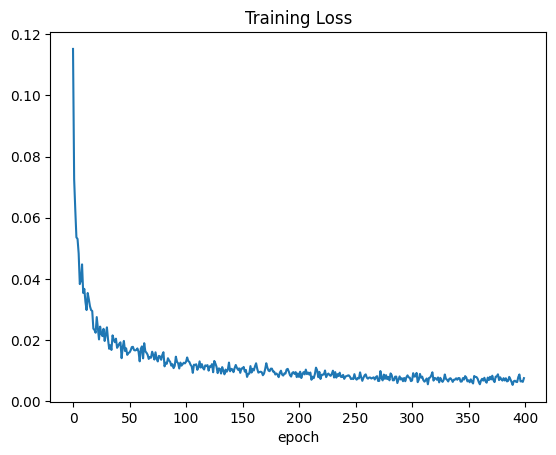

In [15]:
plt.plot(loss_)
plt.title("Training Loss")
plt.xlabel("epoch")
plt.show()

In [18]:
#모델 평가는 RMSE로 진행
def evaluation(dataloader):
    
    predictions = torch.tensor([], dtype=torch.float) # 예측값을 저장하는 텐서
    actual = torch.tensor([], dtype=torch.float) # 실제값을 저장하는 텐서
        
    with torch.no_grad(): #평가를 위해 gradient 제거
        model.eval() # 평가를 할 때에는 .eval() 반드시 사용해야 한다.
        for data in dataloader:
            inputs, values = data
            outputs = model(inputs)

            predictions = torch.cat((predictions, outputs), 0) # cat을 통해 output을 predictions에 예측값을 누적
            actual = torch.cat((actual, values), 0) # cat을 통해 실제값을 누적
    
    predictions = predictions.numpy() # 넘파이 배열로 변경
    actual = actual.numpy() # 넘파이 배열로 변경
    rmse = np.sqrt(mean_squared_error(predictions, actual)) # sklearn을 이용하여 RMSE 계산 sqrt로 제곱근
    
    return rmse  

# 평가 시 .eval()을 사용해야 하는 이유
# 평가 시에는 온전한 모델로 평가를 해야하는데 .eval()이 아닌 .train()인 경우 드랍아웃이 활성화 되어 있다.
# 따라서 드랍아웃이나 배치 정규화 등과 같이 학습 시에만 사용하는 기술들을 평가 시에는 비활성화 해야만 한다.

In [19]:
train_rmse = evaluation(trainloader) # 학습 데이터의 RMSE
test_rmse = evaluation(testloader) # 시험 데이터의 RMSE

print("Train RMSE: ",train_rmse)
print("Test RMSE: ",test_rmse)

# 예시를 위한 단순 비교입니다. 실제 연구에서는 디테일한 비교가 필요합니다.
# 데이터를 무작위로 나누고 모델의 초기값도 random initial parameter를 사용했기 때문에 학습을 할 때 마다 결과가 다르게 나올 수 있습니다.
# 이 강의에서는 학습의 흐름(for문)과 모델(Regressor) 부분을 주의 깊게 보시면 됩니다.

Train RMSE:  0.06325907
Test RMSE:  0.11627649


### train과 Test 차이가 꽤 크다 => 과적합 판단 가능